In [2]:
import pandas as pd
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 99

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
### Algoritmo

# Cargar base de datos y mergear por codigo
# (Deptos en Base del Censo son los mismo que tiene Rodriguez?)

# lo que no esta OK o no coincide codigo va todo a compararse en spatial join

# Se concatenan resultados

In [5]:
year = '2010'

### Codigos de Fracciones segun base de datos

In [6]:
path_ = './censos_db_ref/'+year

if year == '1991':
    censo = pd.read_csv(path_ + '/FRACCION.csv', ';'
                       ).merge(pd.read_csv(path_ + '/DEPTO.csv', ';')
                             ).merge(pd.read_csv(path_ + '/PROVIN.csv', ';'))
    censo = censo.rename(columns = {'PROVIN': 'IDPROV', 'DEPTO': 'IDDPTO', 'FRACCION': 'IDFRAC', 'RADIO': 'IDRADIO'})
    
else:
    censo = pd.read_csv(path_ + '/FRAC.csv', ';'
                  ).merge(pd.read_csv(path_ + '/DPTO.csv', ';')
                         ).merge(pd.read_csv(path_ + '/PROV.csv', ';'))
    
# df['COD_1991'] = df['IDPROV'].astype(str).str.zfill(2) + df['IDDPTO'].astype(str).str.zfill(3) \
# + df['IDFRAC'].astype(str).str.zfill(2) + df['IDRADIO'].astype(str).str.zfill(2)

## Este df tiene Antartida e Islas, que en el archivo de Rodriguez no estan.
# 94021 Antártida Argentina, 94028 Islas del Atlántico Sur
# Se mergean por codigo, igual...

# # Excluyo CABA, en censos1991, 2001
# censo = censo.loc[censo.PROV != 2]

## Adapto columnas para mergear
censo['PROV_'] = censo.IDPROV.astype(str).str.zfill(2)
censo['DEPTO_'] = censo.IDDPTO.astype(str).str.zfill(3)
censo['FRACC_'] = censo.IDFRAC.astype(str).str.zfill(2)

### Informacion espacial en Censo (2010)

In [6]:
## Solo para el CRS:
dptos_censo_shp = gpd.read_file('./censos_shp_CONICET_dissolved/dptos_'+year+'.shp')
CONICET_INDEC_crs = dptos_censo_shp.crs

In [8]:
# dptos_censo_shp.crs

### Referencia IGN

In [8]:
import geopandas as gpd

In [9]:
ref_ = gpd.read_file('./IGN_shp/ign_departamento/')
ref_.loc[ref_.IN1 == '60441', 'IN1'] = '06441'   # Error en el codigo de area de La Plata
ref_ = ref_.loc[~ref_.IN1.isin(['94028', '94021'])] # Excluir Antartida e Islas
ref_ = ref_.to_crs(dptos_censo_shp.crs)
# ref_['PROV_'] = ref_['IN1'].str[:2]
# ref_['DEPTO_'] = ref_['IN1'].str[2:]  # Esto esta 'mal', porque IN1 actualizo codigos. Pero justamente vamos a querer ver cuando DEPTO_ segun IGN no coincide con DEPTO_ en Censo

In [10]:
ref_provs = gpd.read_file('./IGN_shp/Provincia/')
ref_provs = ref_provs.to_crs(dptos_censo_shp.crs)
ref_provs['PROV_'] = ref_provs['IN1']

ref_provs.head(2)

,OBJECTID,Entidad,Objeto,FNA,GNA,NAM,SAG,FDC,IN1,SHAPE_STAr,SHAPE_STLe,geometry,PROV_
0,427,0,Provincia,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma,Ciudad Autónoma de Buenos Aires,IGN,Geografía,02,0.020242,0.743806,"POLYGON Z ((4202961.955 6141505.576 0.000, 4202913.501 6141488.854 0.000, 4202775.012 6141441.0...",02
1,428,0,Provincia,Provincia del Neuquén,Provincia,Neuquén,IGN,Geografía,58,9.771811,21.515985,"POLYGON Z ((3104529.599 5990240.027 0.000, 3104571.120 5989730.595 0.000, 3104581.804 5989403.3...",58


## Unir IGN y Censo

In [11]:
### Tengo cierta informacion.
dptos_join_censo = gpd.GeoDataFrame(pd.read_csv('./crosw_INDEC_'+year+'.csv', dtype = str).merge(dptos_censo_shp)[['PROV_','DEPTO_', 'geometry']])
dptos_join_IGN = gpd.GeoDataFrame(pd.read_csv('./crosw_IGN_'+year+'.csv', dtype = str).merge(ref_)[['IN1', 'NAM', 'geometry']])

## Acordarse del codigo de partido de la plata, ademas de los codigos de CABA, que fueron cambiados.

In [12]:
## Intersecciones entre los deptos en censo que han cambiado (ej. Chascomus) y los deptos en IGN que no aparecieron en censo (Ej. el 'nuevo' Chascomus y  Lezama)
crossw_geo = gpd.overlay(dptos_join_censo, dptos_join_IGN, how='intersection')

In [31]:
# # Ejemplo, antiguos distritos escolares a Comunas
# from shapely.geometry import box
# import matplotlib.pyplot as plt
# %matplotlib inline

# if year != '2010':
#     fig, ax = plt.subplots(1, figsize = (7, 7))

#     CABA = crossw_geo.loc[crossw_geo.PROV_ == '02']
#     CABA.dissolve('DEPTO_').plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
#     CABA.dissolve('IN1').plot(color = 'None', edgecolor = 'g', ax = ax, lw = .5)

#     # plot bounds
#     x0, y0, x1, y1 = box(*CABA.total_bounds).buffer(2000).bounds  ## 2km alrededor de CABA
#     # minx, miny, maxx, maxy

#     ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
#     ax.axis('off')

#     plt.show()


In [14]:
## Ahora, hacer la interseccion espacial entre cada deptos del censo con los de IGN.
CONICET_radios = gpd.read_file('./censos_shp_CONICET/'+year+'_RADIOS ARGENTINA/')[['PROV_','DEPTO_', 'FRACC_', 'COD_'+year, 'geometry']]

## El archivo de rodriguez de 2010 tiene un problemita por el cual los codigos de deptos de la provincia de Formosa fueron sobreescritos con los codigos de fracciones. 
# Para constatar que afecta solamente a todas las entradas de formosa (PROV 34)
# (CONICET_radios['COD_2010'].str[2:5] == CONICET_radios.DEPTO_).groupby(CONICET_radios.PROV_).sum()/CONICET_radios.groupby(CONICET_radios.PROV_).size()
if year == '2010':    # Lo corregimos
    CONICET_radios['DEPTO_'] = CONICET_radios['COD_2010'].str[2:5]


CONICET_radios['DEPTO_'] = CONICET_radios['DEPTO_'].str.zfill(3)
CONICET_radios['geometry'] = CONICET_radios['geometry'].buffer(1) # Un metro de buffer para garantizar que no queden marcas entre radios

## De un lado los radios a ubicar, aquellos en los deptos viejos (y en CABA previo a las comunas).
radios_ubicar = gpd.GeoDataFrame(dptos_join_censo[['PROV_','DEPTO_']].drop_duplicates().merge(CONICET_radios))

In [15]:
radios_ubicar.head()

,PROV_,DEPTO_,FRACC_,COD_2010,geometry
0,06,217,02,062170204,"POLYGON ((4224012.353 6061064.263, 4224012.432 6061064.323, 4224012.517 6061064.376, 4224012.60..."
1,06,217,02,062170201,"POLYGON ((4223584.309 6060701.223, 4223584.383 6060701.287, 4223584.463 6060701.344, 4223584.54..."
2,06,217,02,062170205,"POLYGON ((4235934.308 6054808.722, 4235934.382 6054808.786, 4235934.461 6054808.842, 4235934.54..."
3,06,217,02,062170203,"POLYGON ((4223423.521 6048031.297, 4223423.505 6048031.399, 4223423.500 6048031.501, 4223423.50..."
4,06,217,02,062170206,"POLYGON ((4232058.272 6043513.314, 4232058.239 6043513.351, 4231000.739 6044752.351, 4231000.68..."


In [16]:
## Intersectar los radios en cuestion con los polis de IGS.
inters = gpd.overlay(radios_ubicar, dptos_join_IGN[['IN1', 'geometry']], how='intersection')
inters['area'] = inters.area

# Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
radios_in_depto = inters.groupby(['PROV_', 'DEPTO_', 'COD_'+year]).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True)[['PROV_', 'DEPTO_', 'COD_'+year, 'IN1']]
radios_in_depto['FRACC_'] = radios_in_depto['COD_'+year].str[5:7]


In [17]:
## Test: se perdio algun radio? Puede pasar por algunos detalles de proyeccion
if not radios_in_depto['COD_'+year].nunique() == radios_ubicar['COD_'+year].nunique():
    print('Hubo radios sin interseccion')

In [18]:
radios_in_depto.head()

,PROV_,DEPTO_,COD_2010,IN1,FRACC_
0,06,217,062170101,06218,01
1,06,217,062170102,06218,01
2,06,217,062170103,06218,01
3,06,217,062170104,06218,01
4,06,217,062170105,06218,01


In [22]:
CONICET_radios_IGN = CONICET_radios.merge(radios_in_depto, how = 'left')

CONICET_radios_IGN['IN1'] = CONICET_radios_IGN.PROV_ + CONICET_radios_IGN.DEPTO_

# in 2010, CABA esta en comunas, pero los codigos de IGN no son los mismos que usa INDEC.
##  (Son los mismos pero multiplicados por 7.)
# ref_.loc[ref_.IN1.str[:2] == '02'].sort_values('IN1')

if year == '2010':
    CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'IN1'] = CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'PROV_'] + (7 * CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'IN1'].astype(int)).astype(str).str.zfill(3)

In [23]:
CONICET_radios_IGN.head()

,PROV_,DEPTO_,FRACC_,COD_2010,geometry,IN1
0,02,013,03,020130302,"POLYGON ((4192221.072 6153090.127, 4192221.041 6153090.218, 4192221.018 6153090.312, 4192221.00...",0214091
1,02,013,11,020131101,"POLYGON ((4193004.845 6152773.755, 4193004.922 6152773.816, 4193005.004 6152773.869, 4193005.09...",0214091
2,02,013,01,020130104,"POLYGON ((4192183.810 6152816.117, 4192157.781 6152917.752, 4192157.779 6152917.761, 4192148.76...",0214091
3,02,013,01,020130103,"POLYGON ((4192119.388 6153045.932, 4192119.483 6153045.964, 4192119.582 6153045.986, 4192119.68...",0214091
4,02,013,01,020130102,"POLYGON ((4191714.098 6152866.569, 4191714.059 6152866.661, 4191714.030 6152866.757, 4191714.01...",0214091


In [317]:
# ## Chequeo por cambios de codigo

# s1 = set(CONICET_radios_IGN.IN1.unique())
# s2 = set(ref_.IN1.unique())

# s2 - s1 # estan en IGN y no en conicet

# display(ref_[['IN1', 'NAM']].loc[ref_.IN1.isin(s2 - s1)].sort_values('IN1'))

# s1 - s2 ## Estan en conicet y no en IGN

# check = censo[['PROV_', 'DEPTO_', 'NOMBDEPTO']].drop_duplicates()
# display(check.loc[(check.PROV_ + check.DEPTO_).isin(s1 - s2)])

,IN1,NAM
125,02028,Comuna 4
126,02035,Comuna 5
82,02042,Comuna 6
127,02049,Comuna 7
205,02056,Comuna 8
390,02063,Comuna 9
128,02070,Comuna 10
129,02077,Comuna 11
130,02084,Comuna 12
210,02091,Comuna 13


,PROV_,DEPTO_,NOMBDEPTO
0,02,001,Distrito Escolar I
32,02,002,Distrito Escolar II
59,02,003,Distrito Escolar III
73,02,004,Distrito Escolar IV
82,02,005,Distrito Escolar V
90,02,006,Distrito Escolar VI
122,02,008,Distrito Escolar VIII
135,02,009,Distrito Escolar IX
161,02,010,Distrito Escolar I
185,02,011,Distrito Escolar XI


In [27]:
CONICET_radios_IGN.to_file('radios_IGN_'+year)

## Mapas de los distritos que fueron subdivididos

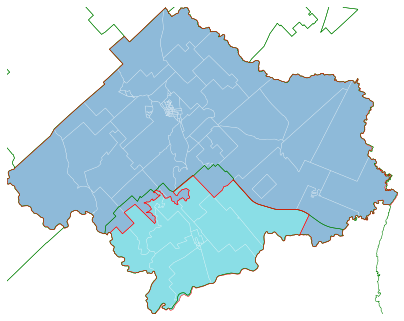

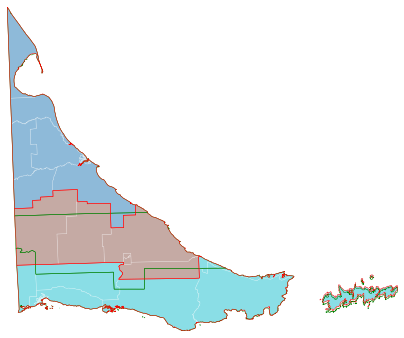

In [28]:

for i, row in crossw_geo[['PROV_']].drop_duplicates().iterrows():
    rads = radios_in_depto.loc[(radios_in_depto.PROV_ == row.PROV_)]
    rads_gdf = gpd.GeoDataFrame(rads.merge(CONICET_radios[['COD_'+year, 'geometry']]))
    
    fig, ax = plt.subplots(1, figsize = (7, 7))
    
    rads_gdf.plot('IN1', ax = ax, alpha = .5, edgecolor = 'w', lw = .4)
    
    ref_.loc[ref_.IN1.str[:2] == row.PROV_].plot(color = 'None', edgecolor = 'g', ax = ax, lw = .5)

    limits = gpd.GeoDataFrame(rads.merge(CONICET_radios[['COD_'+year, 'geometry']])).dissolve('IN1')
    limits.plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
    
    # plot bounds
    x0, y0, x1, y1 = rads_gdf.total_bounds # minx, miny, maxx, maxy
    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.axis('off')

    plt.show()

In [ ]:
# ### Marcar Manual para tener crossw ref
# import pandas as pd
# df = pd.read_csv('./info.csv', dtype = str); 
# df['PROV_'] = df['PROV_'].str.zfill(2); df['DEPTO_'] = df['DEPTO_'].str.zfill(3)

# if year == '1991': 
#     nam_ref = censo[['PROV_', 'DEPTO_', 'NOMBPROV', 'NOMBDEPTO']].drop_duplicates()
# elif year == '2001':
#     nam_ref = censo[['PROV_', 'DEPTO_', 'NOMPROV', 'NOMDEPTO']].drop_duplicates()
# elif year == '2010':
#     nam_ref = censo[['PROV_', 'DEPTO_', 'NOMPROV', 'NOMDPTO']].drop_duplicates()
    
# CABA = nam_ref.loc[nam_ref.PROV_ == '02']

# out = df.merge(nam_ref, how = 'left').dropna()

# if year != '2010':
#     out = pd.concat([out, CABA]).sort_values(['PROV_', 'DEPTO_'])
    
# if year == '1991': 
#     out = out[['PROV_', 'NOMBPROV', 'DEPTO_', 'NOMBDEPTO']]
# elif year == '2001':
#     out = out[['PROV_', 'NOMPROV', 'DEPTO_', 'NOMDEPTO']]
# elif year == '2010':
#     out = out[['PROV_', 'NOMPROV', 'DEPTO_', 'NOMDPTO']]
    
# out = out.drop_duplicates()
# out.to_csv('./crosw_INDEC_'+year+'.csv', index = False)
# out

# ##########################

# df = pd.read_csv('./info_IGN.csv', dtype = str)
# df['IN1'] = df['IN1'].str.zfill(5)

# CABA = ref_.loc[ref_.PROV_ == '02'][df.columns]

# if year != '2010':
#     df = pd.concat([df, CABA]).sort_values(['IN1'])
    
# out = df.drop_duplicates()
# out.to_csv('./crosw_IGN_'+year+'.csv', index = False)
# out